# A Gentle Introduction to Exponential Smoothing with NumPyro

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

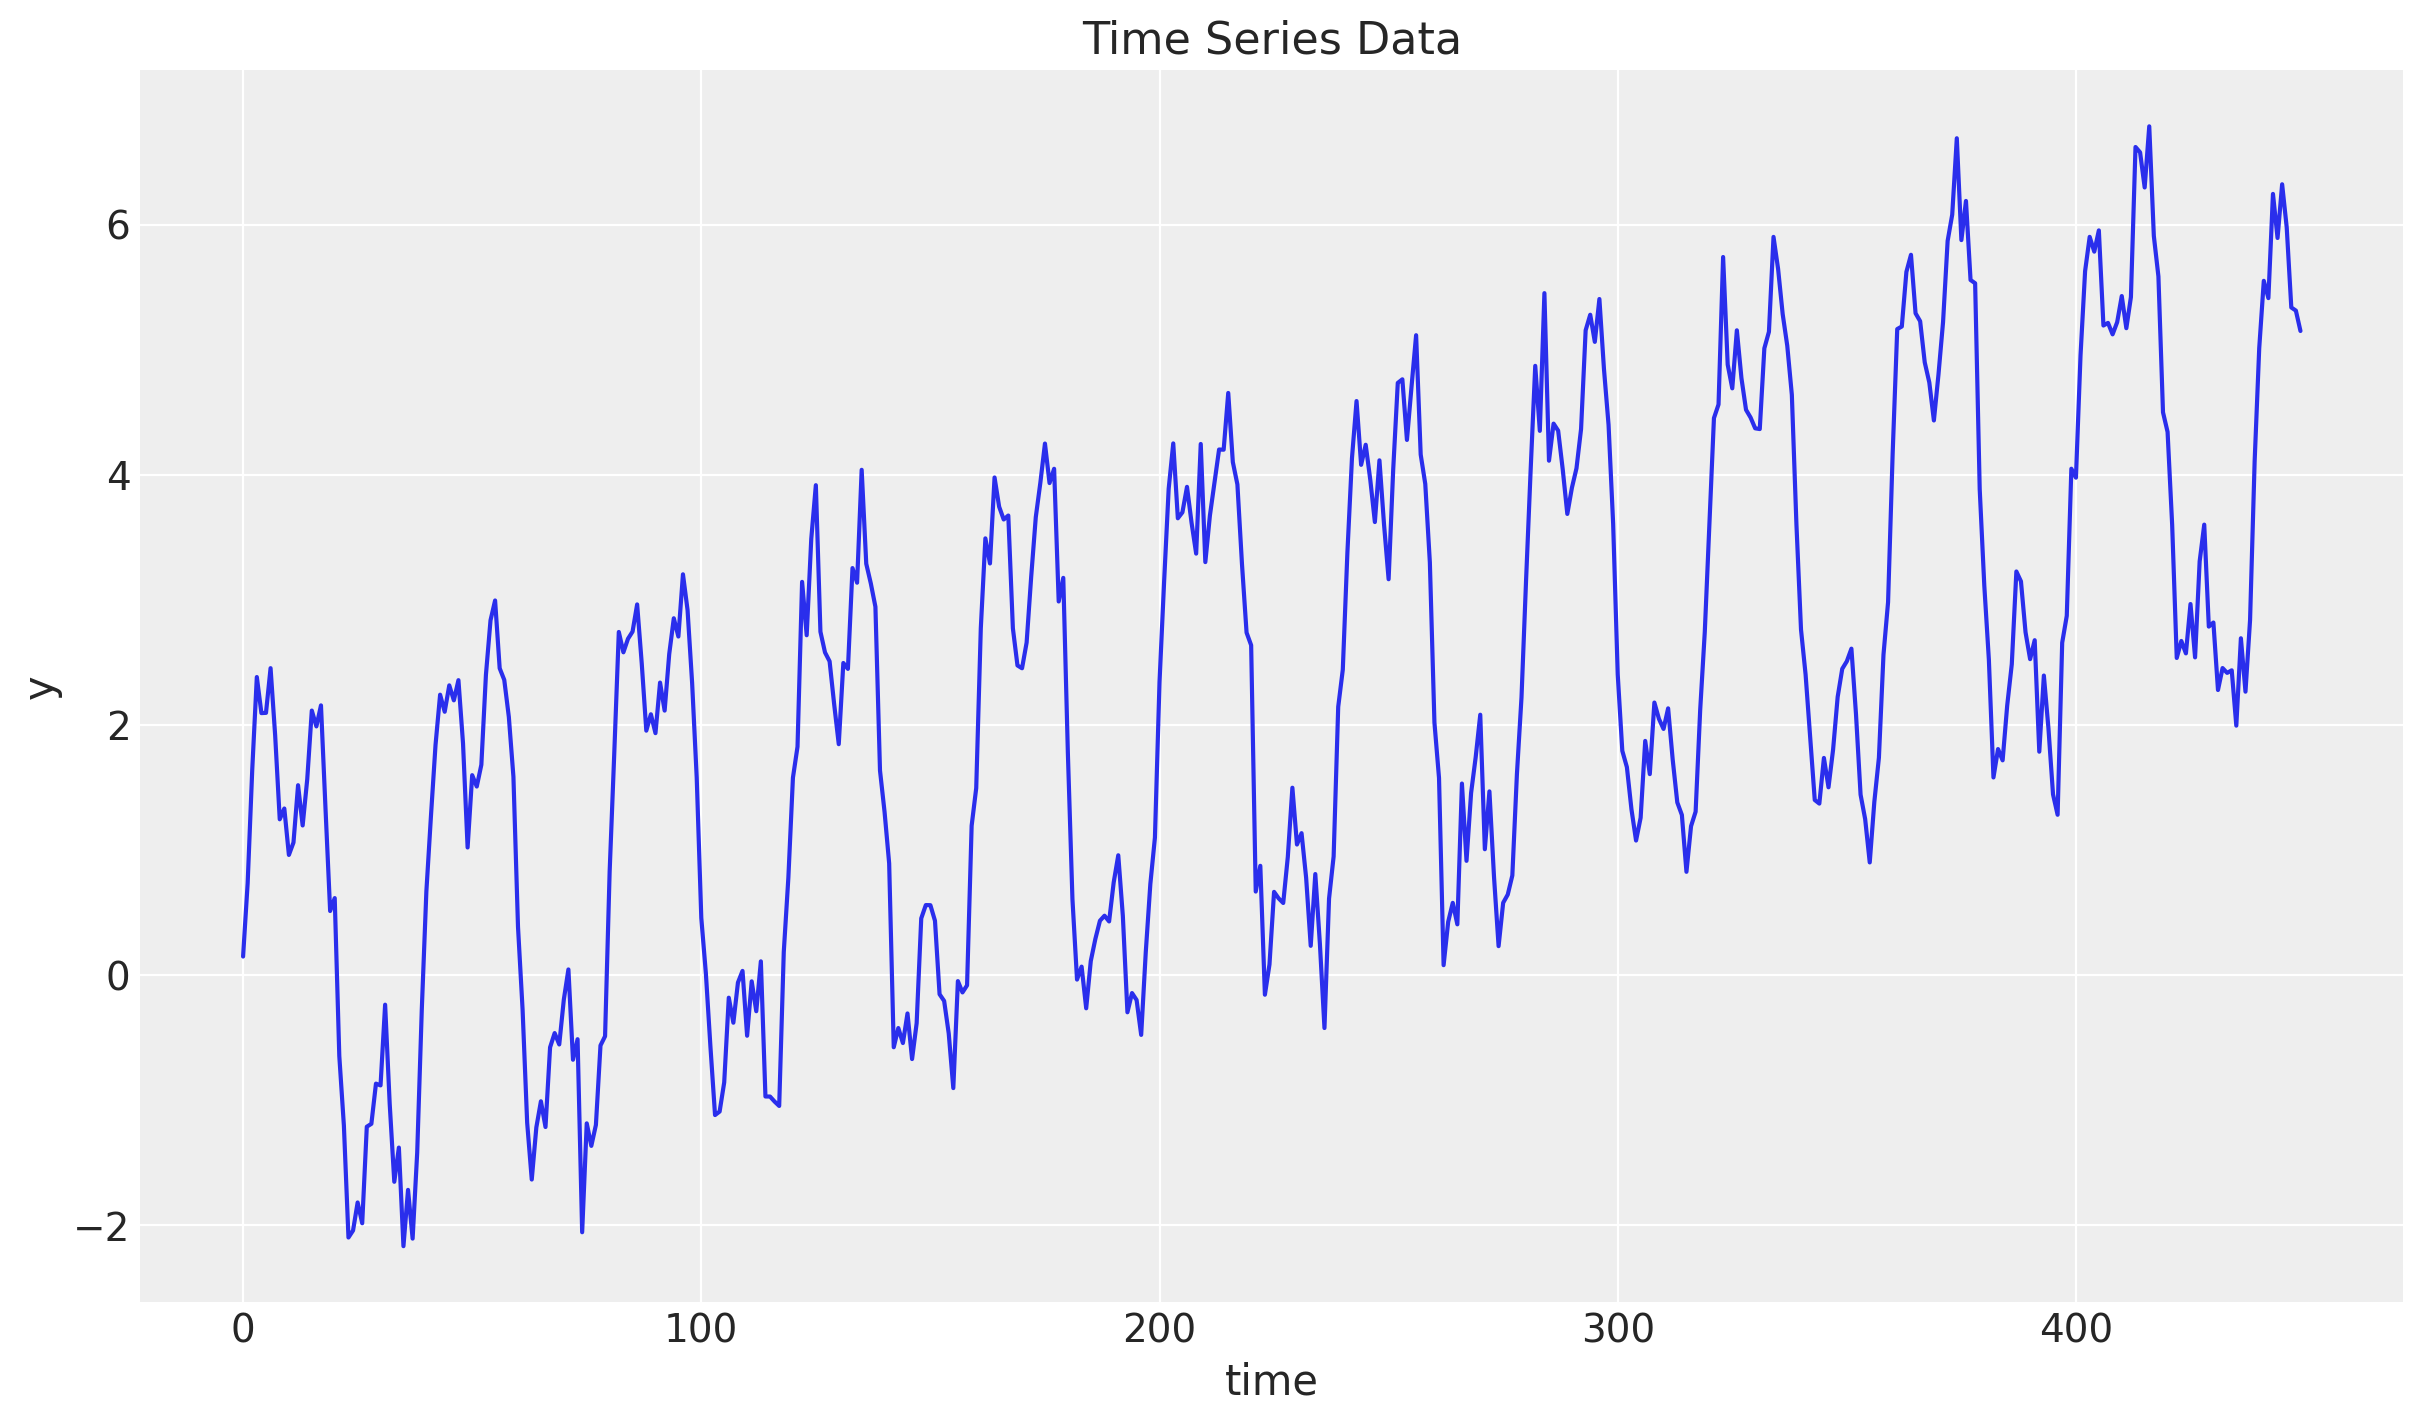

In [2]:
y = jnp.array(
    pd.read_csv("../data/simple_ts_data.csv", usecols=["y"]).to_numpy().flatten()
)

fig, ax = plt.subplots()
ax.plot(y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

## Train - Test Split

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

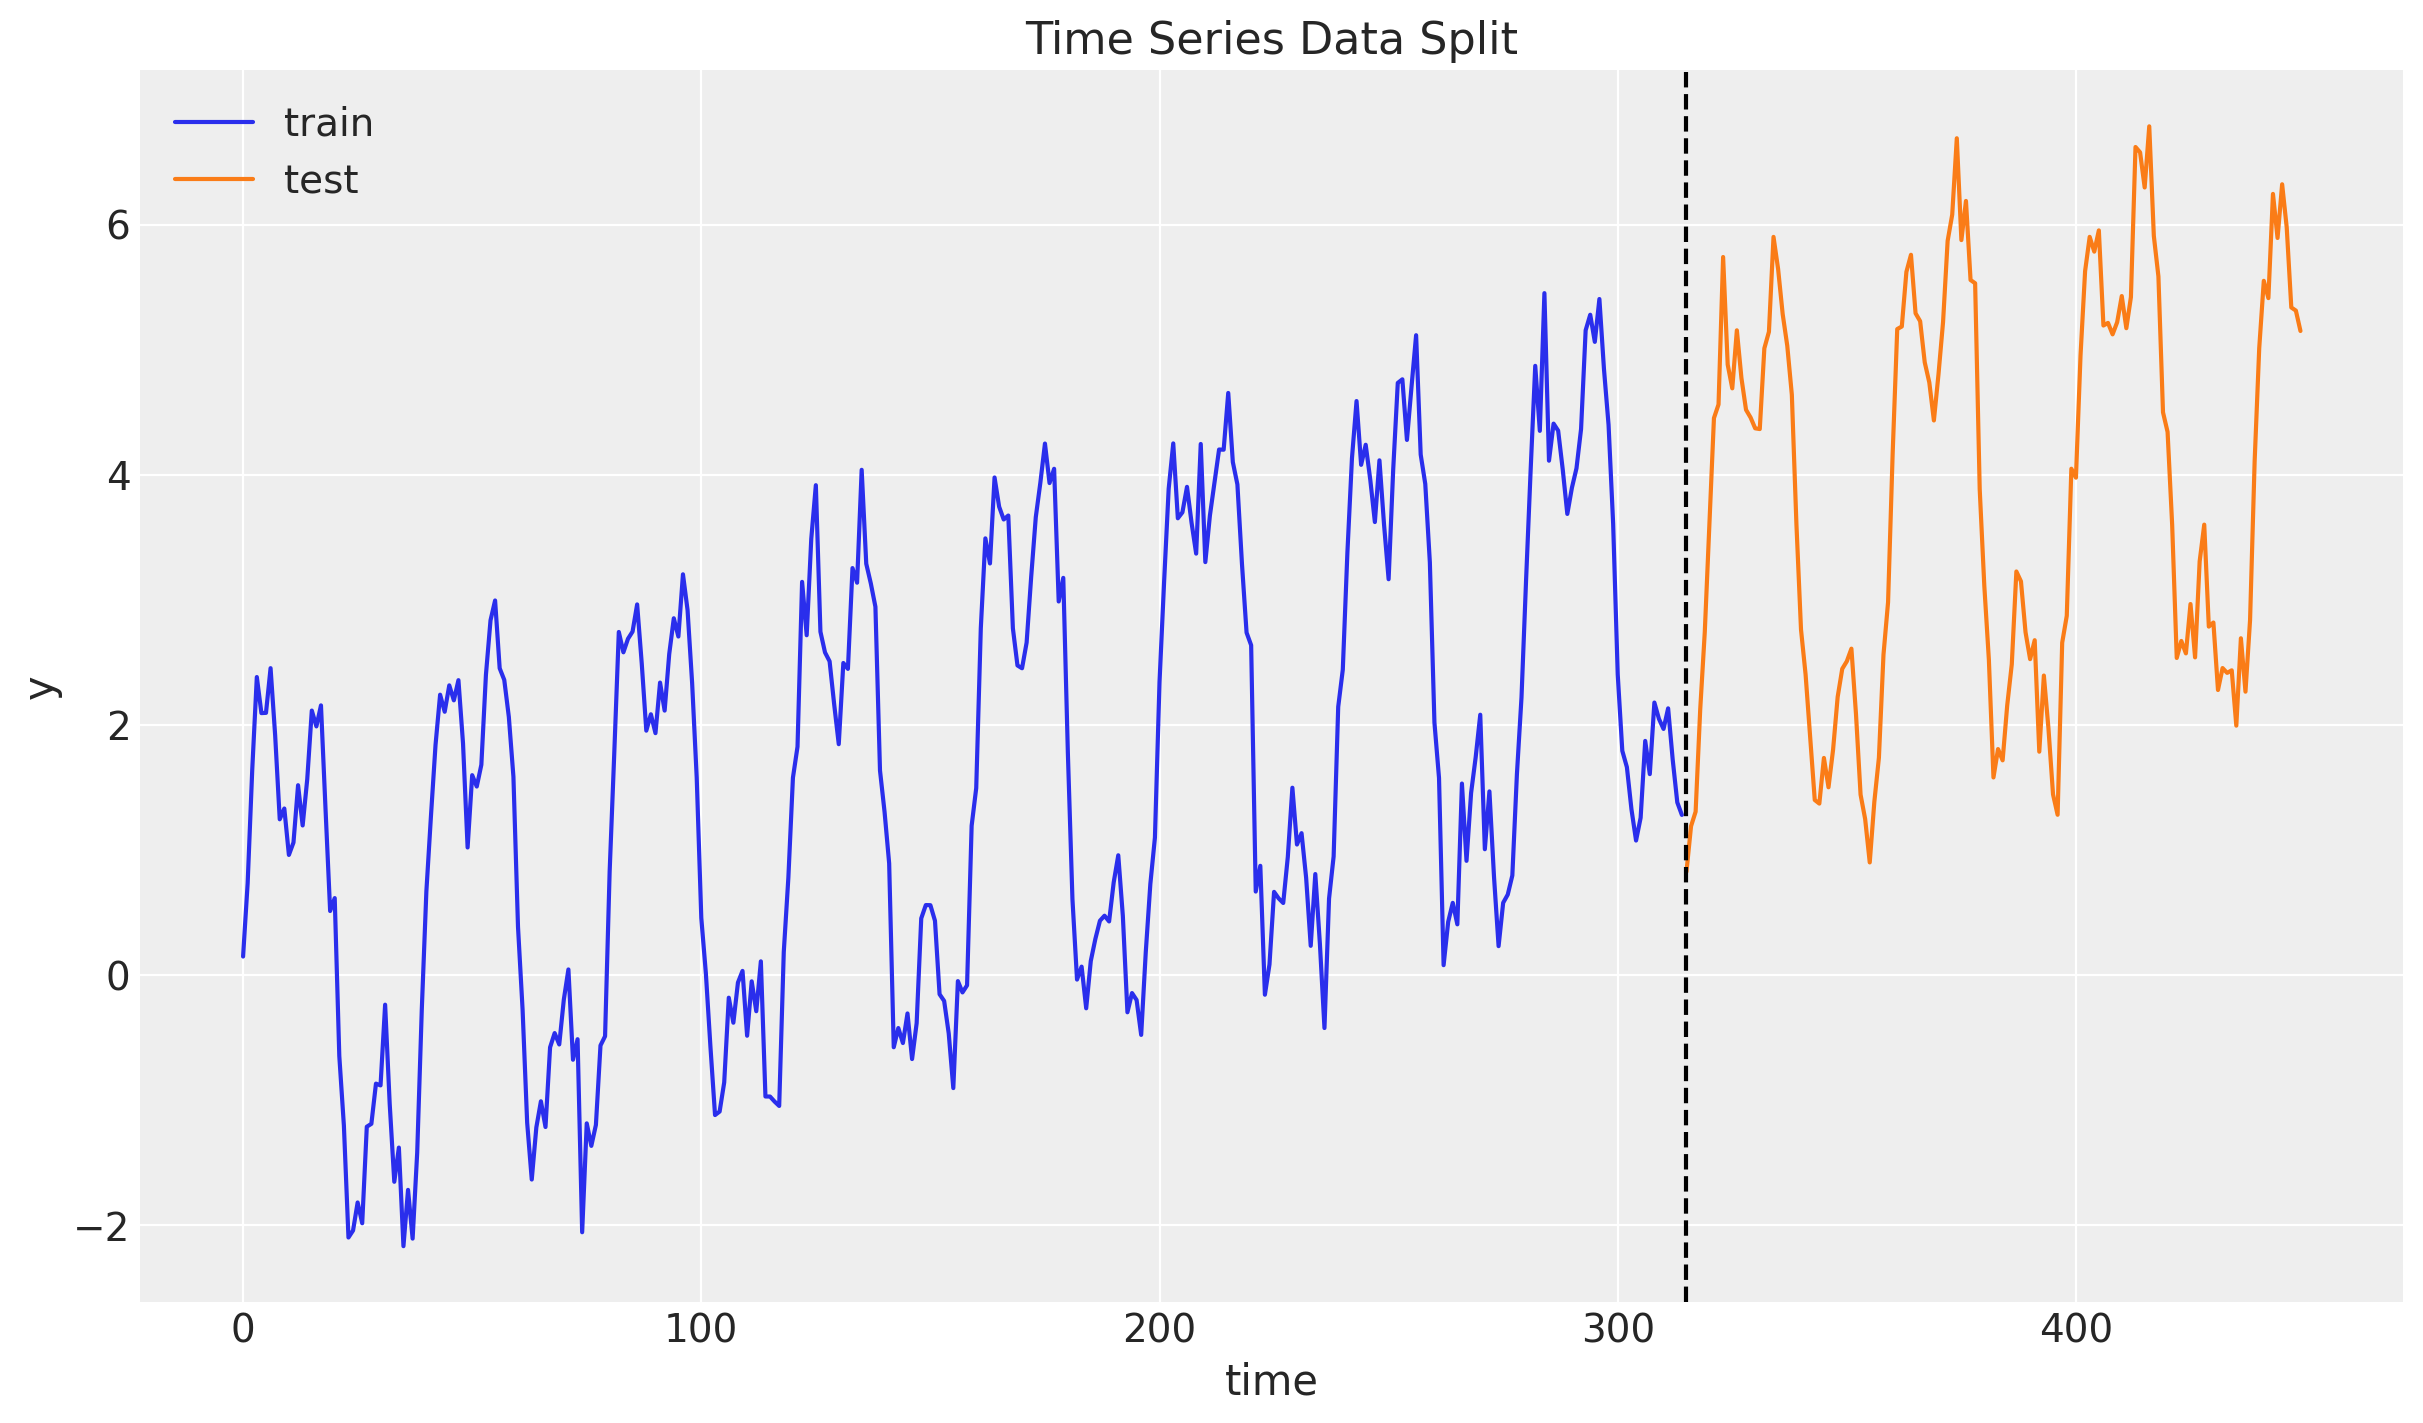

In [3]:
n = y.size

prop_train = 0.7
n_train = round(prop_train * n)

y_train = y[:n_train]
y_test = y[n_train:]

fig, ax = plt.subplots()
ax.plot(range(n_train), y_train, color="C0", label="train")
ax.plot(range(n_train, n), y_test, color="C1", label="test")
ax.axvline(x=n_train, c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

## Level Model

### Model Specification

In [4]:
def level_model(y: ArrayImpl, future: int = 0) -> None:
    # Get time series length
    t_max = y.shape[0]

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level = carry

        # l[t] = alpha * y[t] + (1 - alpha) * l[t - 1]
        level = jnp.where(
            t < t_max,
            level_smoothing * y[t] + (1 - level_smoothing) * previous_level,
            previous_level,
        )

        # y[t + h] ~ Normal(l[t], sigma)
        mu = previous_level
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        return level, pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            level_init,
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

### Inference

In [5]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl, model: Callable, args: InferenceParams, *model_args
) -> MCMC:
    sampler = NUTS(model)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [6]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
level_mcmc = run_inference(rng_subkey, level_model, inference_params, y_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [7]:
level_idata = az.from_numpyro(posterior=level_mcmc)

az.summary(data=level_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_init,0.123,0.505,-0.780,1.112,0.007,0.006,5964.0,4187.0,1.0
level_smoothing,0.984,0.015,0.957,1.000,0.000,0.000,4985.0,3154.0,1.0
noise,0.592,0.023,0.550,0.637,0.000,0.000,6752.0,4834.0,1.0


Text(0.5, 0.98, 'Level Model Trace')

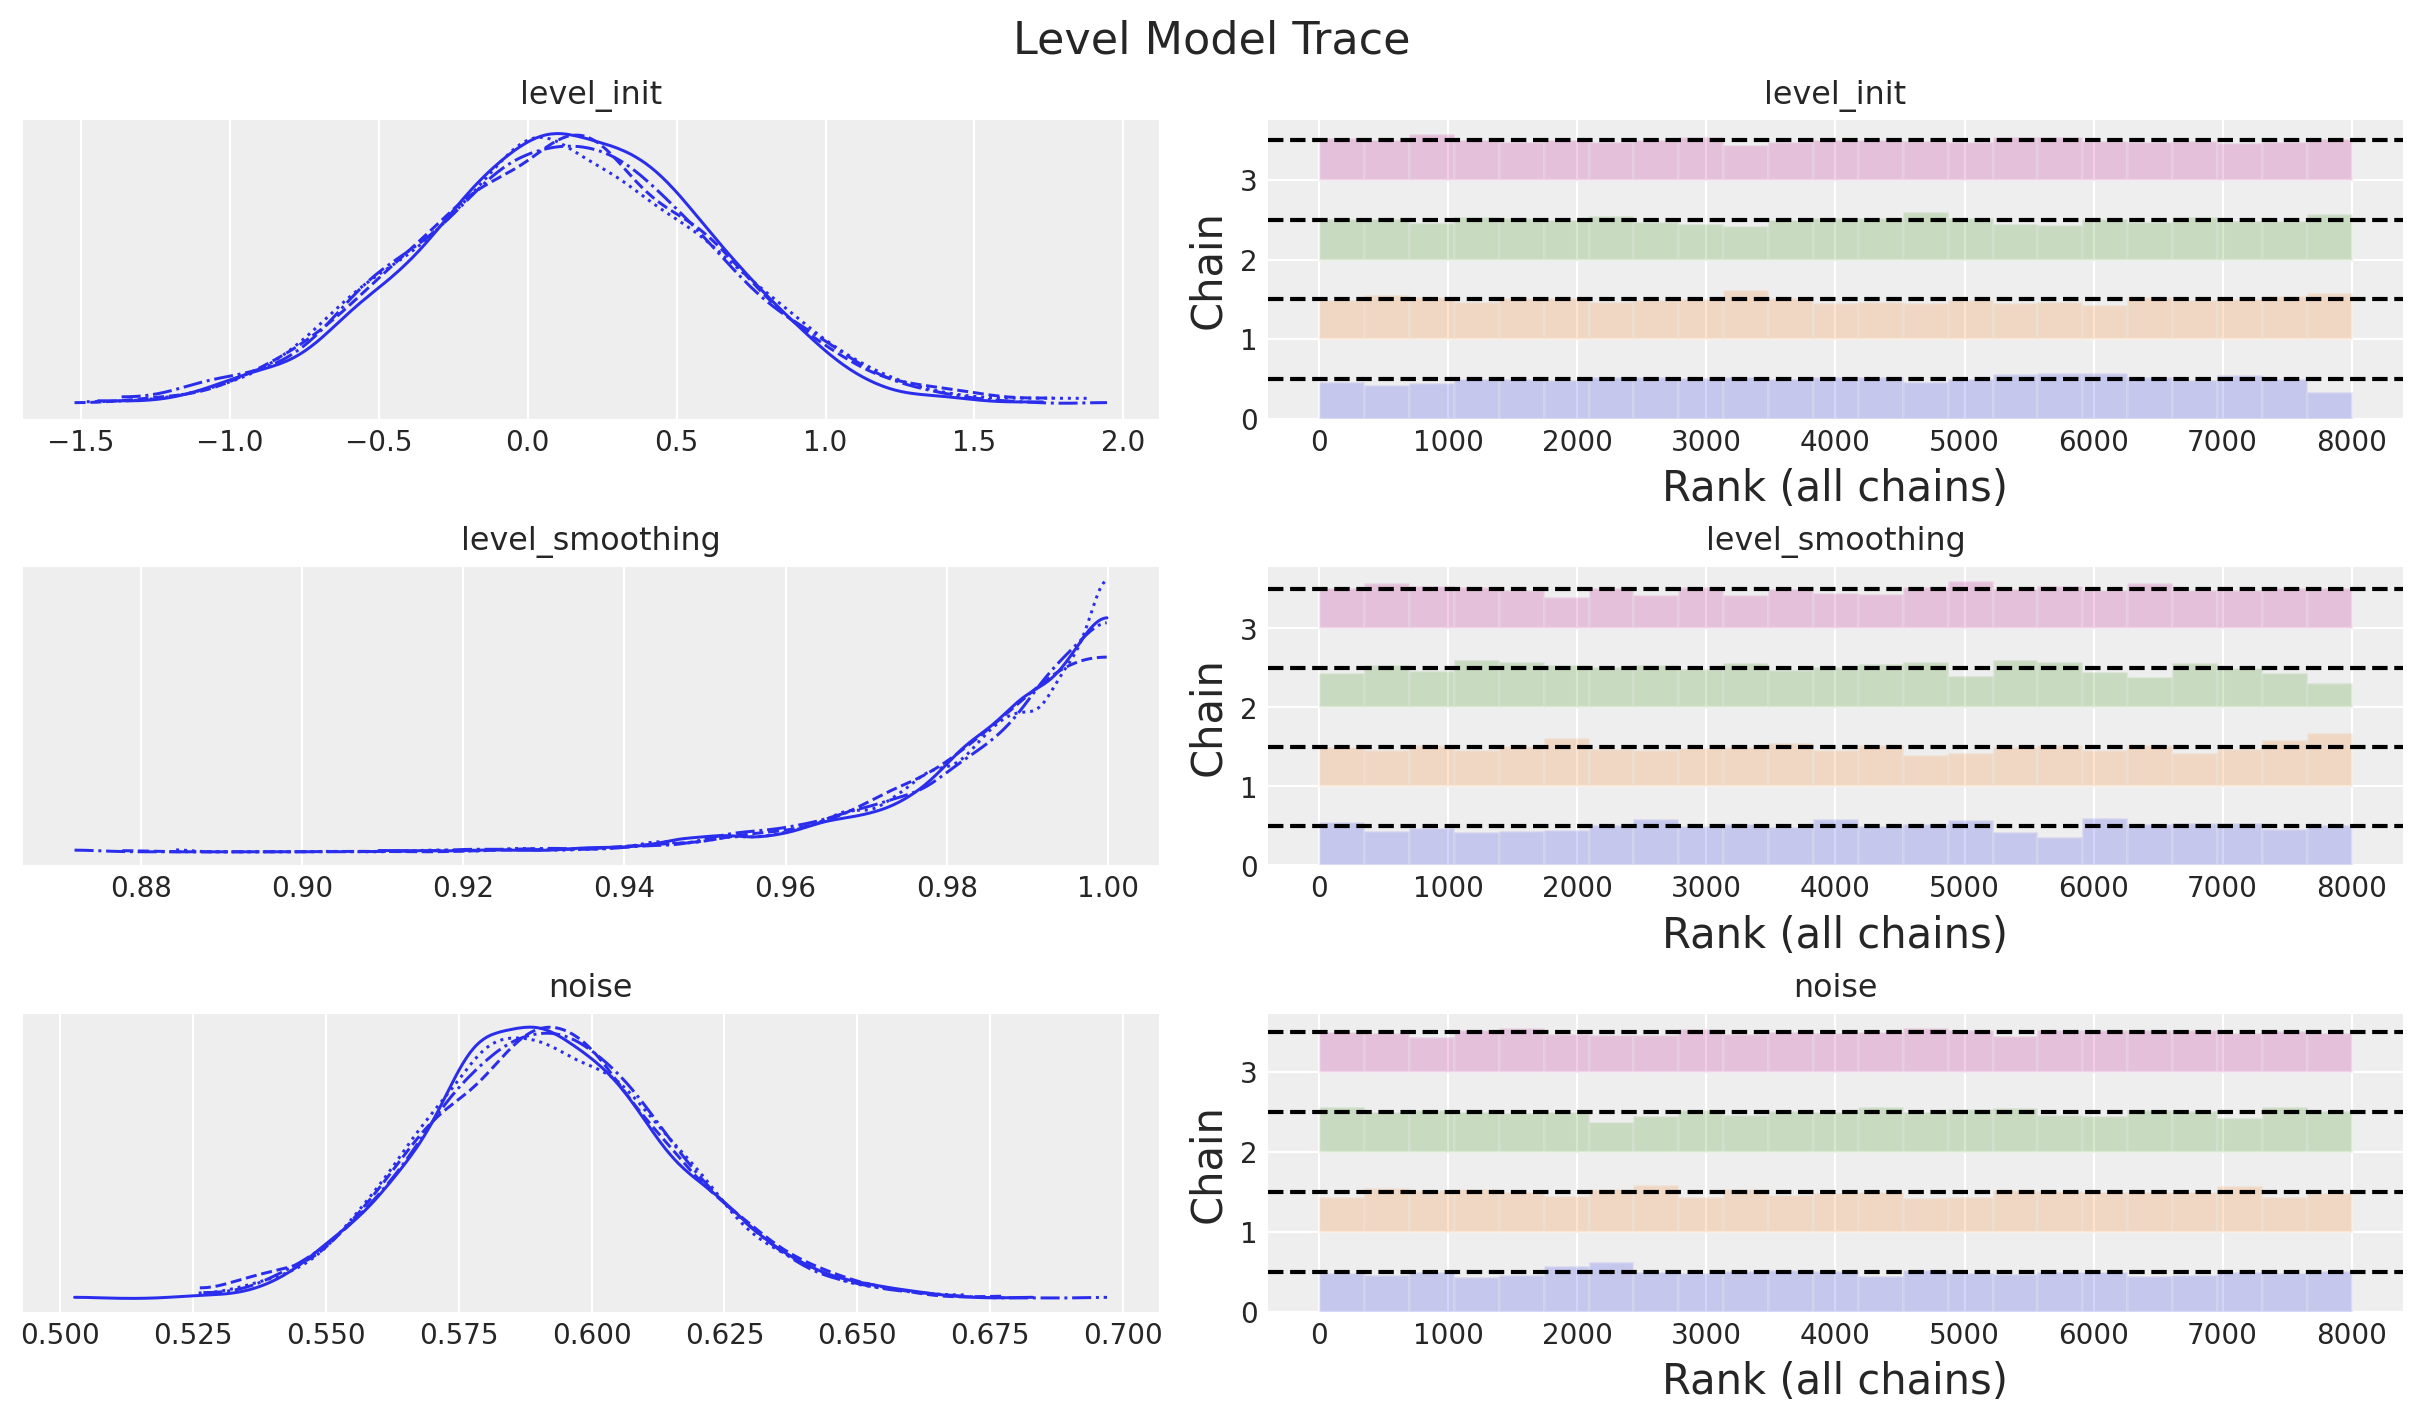

In [8]:
axes = az.plot_trace(
    data=level_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Level Model Trace", fontsize=16)

### Forecast

In [9]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["y_forecast"],
    )
    return predictive(rng_key, *model_args)

In [10]:
rng_key, rng_subkey = random.split(key=rng_key)
level_forecast = forecast(
    rng_subkey, level_model, level_mcmc.get_samples(), y_train, y_test.size
)

In [11]:
level_posterior_predictive = az.from_numpyro(
    posterior_predictive=level_forecast,
    coords={"t": range(n_train, n)},
    dims={"y_forecast": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Level Model Forecast')]

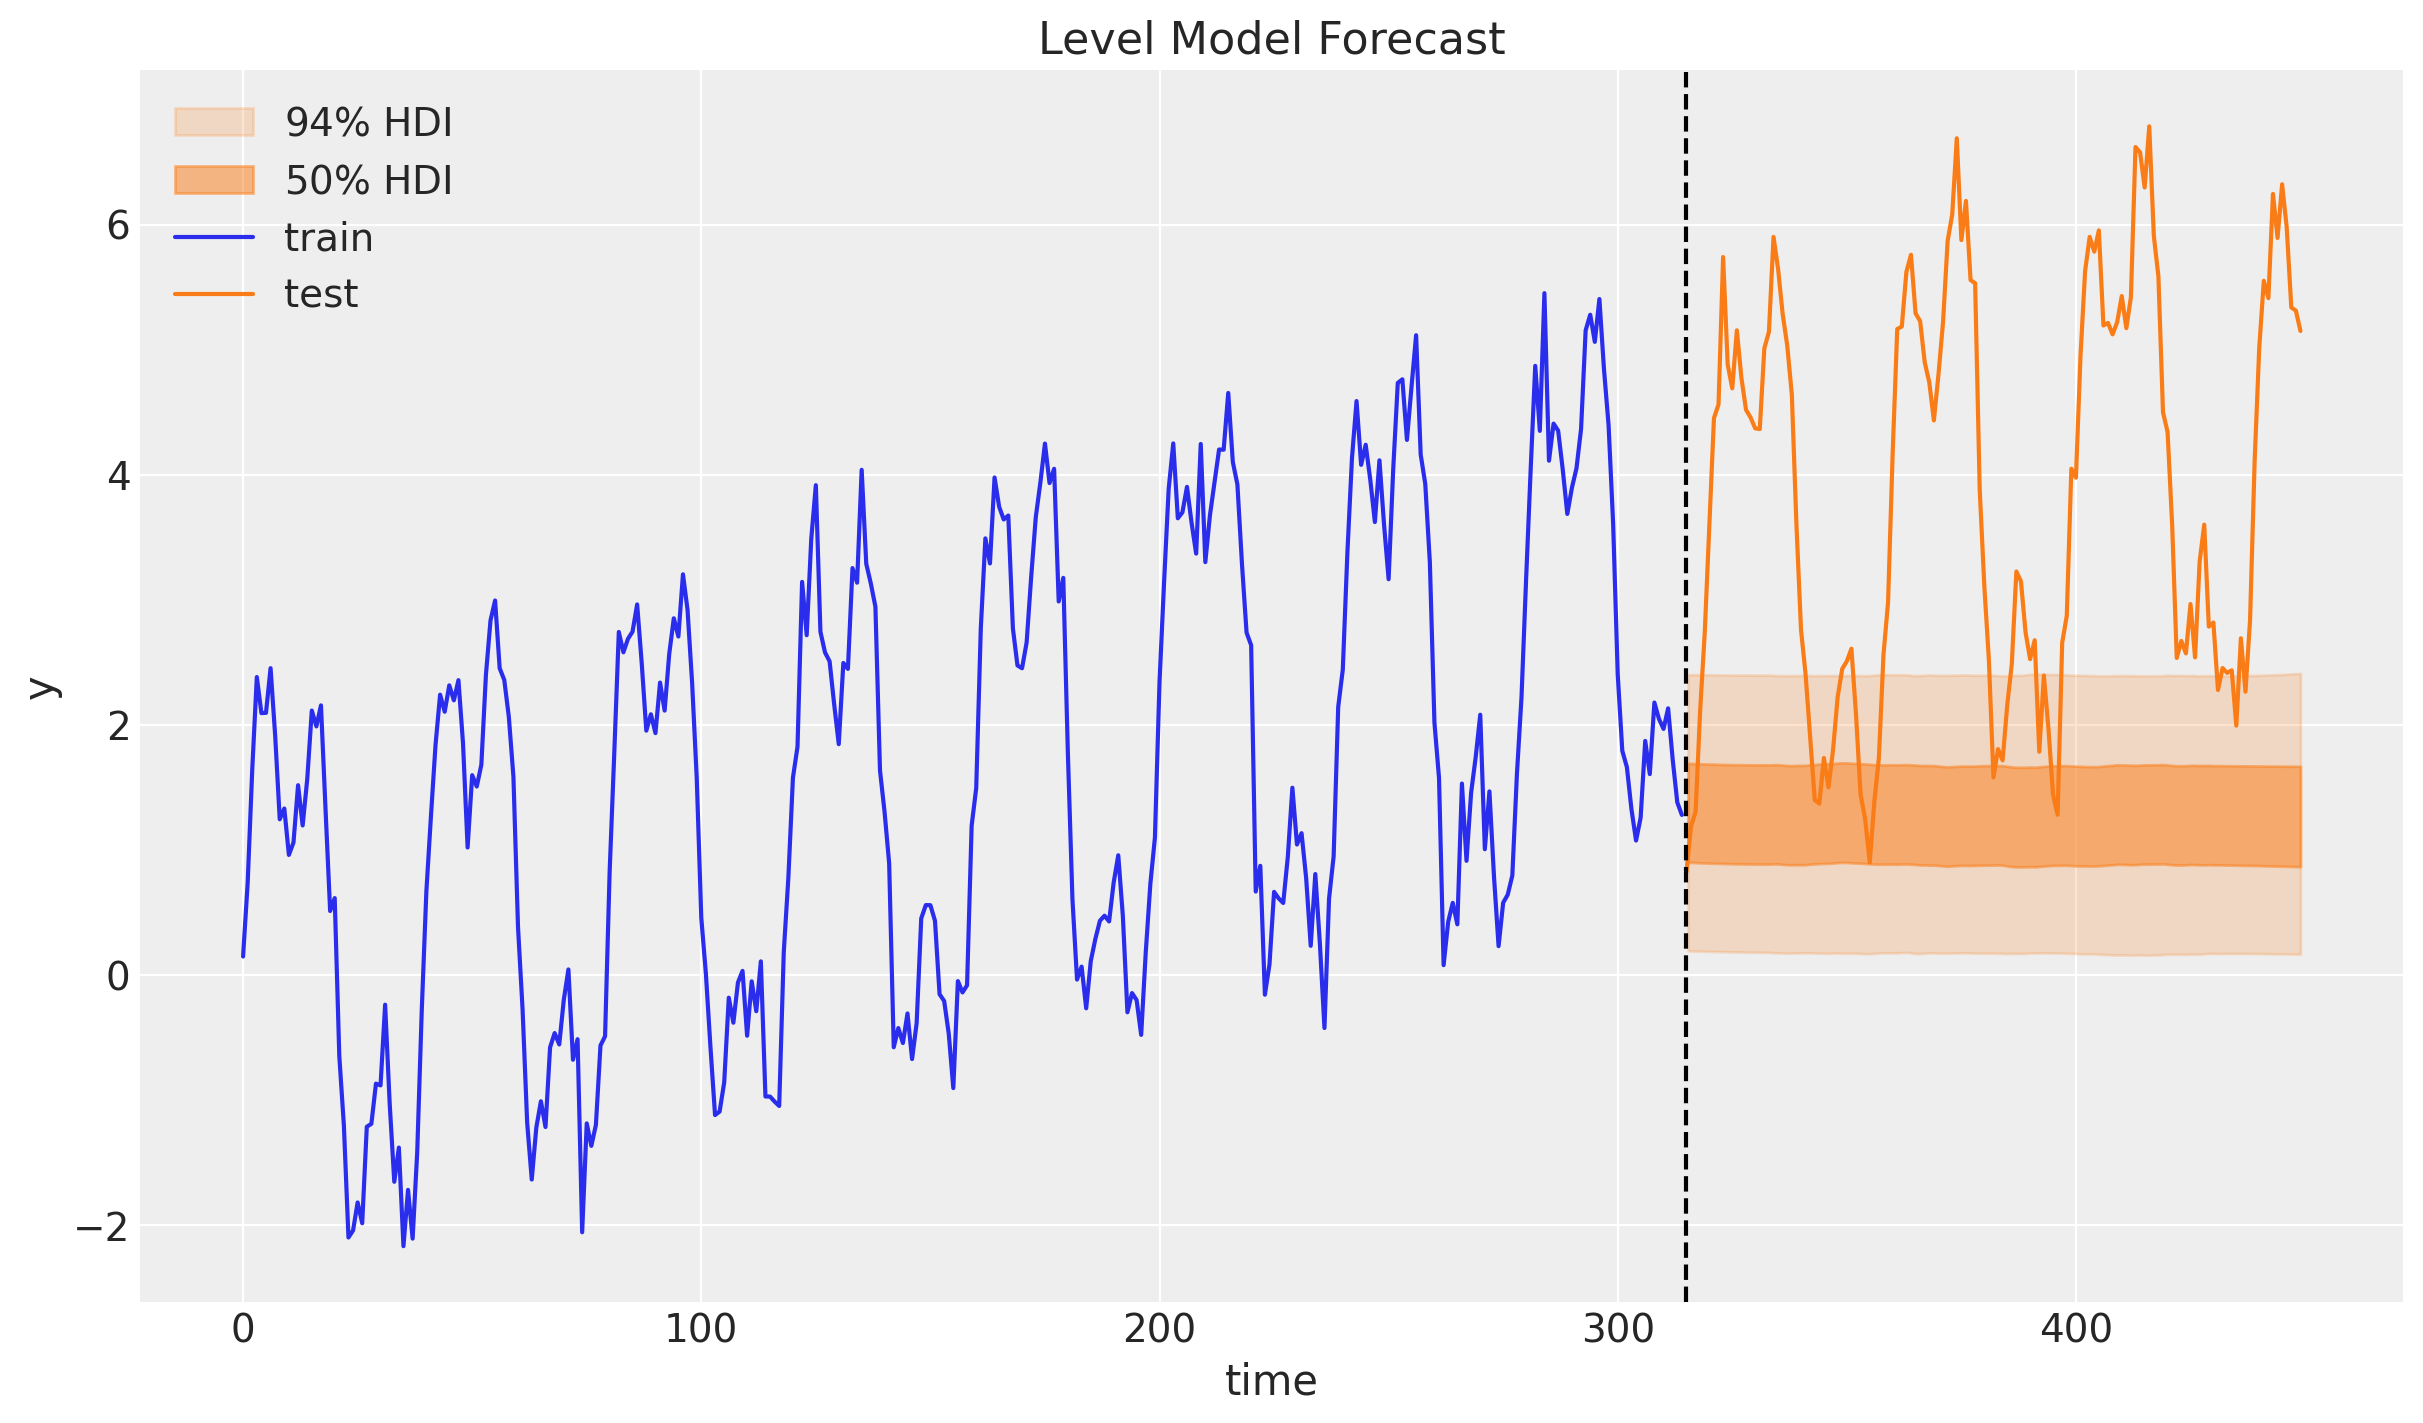

In [12]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=range(n_train, n),
    y=level_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    range(n_train, n),
    level_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(range(n_train), y_train, color="C0", label="train")
ax.plot(range(n_train, n), y_test, color="C1", label="test")
ax.axvline(x=n_train, c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level Model Forecast")

## Level + Trend Model

### Model Specification

In [20]:
def level_trend_model(y: ArrayImpl, future: int = 0) -> None:
    # Get time series length
    t_max = y.shape[0]

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    ## Trend
    trend_smoothing = numpyro.sample("trend_smoothing", dist.Beta(1, 1))
    trend_init = numpyro.sample("trend_init", dist.Normal(0, 1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level, previous_trend = carry

        # l[t] = alpha * y[t] + (1 - alpha) * (l[t - 1] + b[t - 1])
        level = jnp.where(
            t < t_max,
            level_smoothing * y[t]
            + (1 - level_smoothing) * (previous_level + previous_trend),
            previous_level,
        )

        # b[t] = beta * (l[t] - l[t - 1]) + (1 - beta) * b[t - 1]
        trend = jnp.where(
            t < t_max,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * previous_trend,
            previous_trend,
        )

        step = jnp.where(t < t_max, 1, t - t_max + 1)

        # y[t + h] ~ Normal(l[t] + h * b[t], sigma)
        mu = previous_level + step * previous_trend
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        return (level, trend), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init),
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

### Inference

In [21]:
rng_key, rng_subkey = random.split(key=rng_key)
level_trend_mcmc = run_inference(
    rng_subkey, level_trend_model, inference_params, y_train
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [22]:
level_trend_idata = az.from_numpyro(posterior=level_trend_mcmc)

az.summary(data=level_trend_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_init,-0.457,0.475,-1.343,0.448,0.006,0.005,6180.0,5124.0,1.0
level_smoothing,0.662,0.041,0.594,0.742,0.001,0.000,4931.0,3813.0,1.0
noise,0.587,0.023,0.544,0.631,0.000,0.000,6051.0,4874.0,1.0
trend_init,0.616,0.456,-0.235,1.468,0.006,0.004,5905.0,5365.0,1.0
trend_smoothing,0.902,0.078,0.757,1.000,0.001,0.001,3882.0,3620.0,1.0


Text(0.5, 0.98, 'Level + Trend Model Trace')

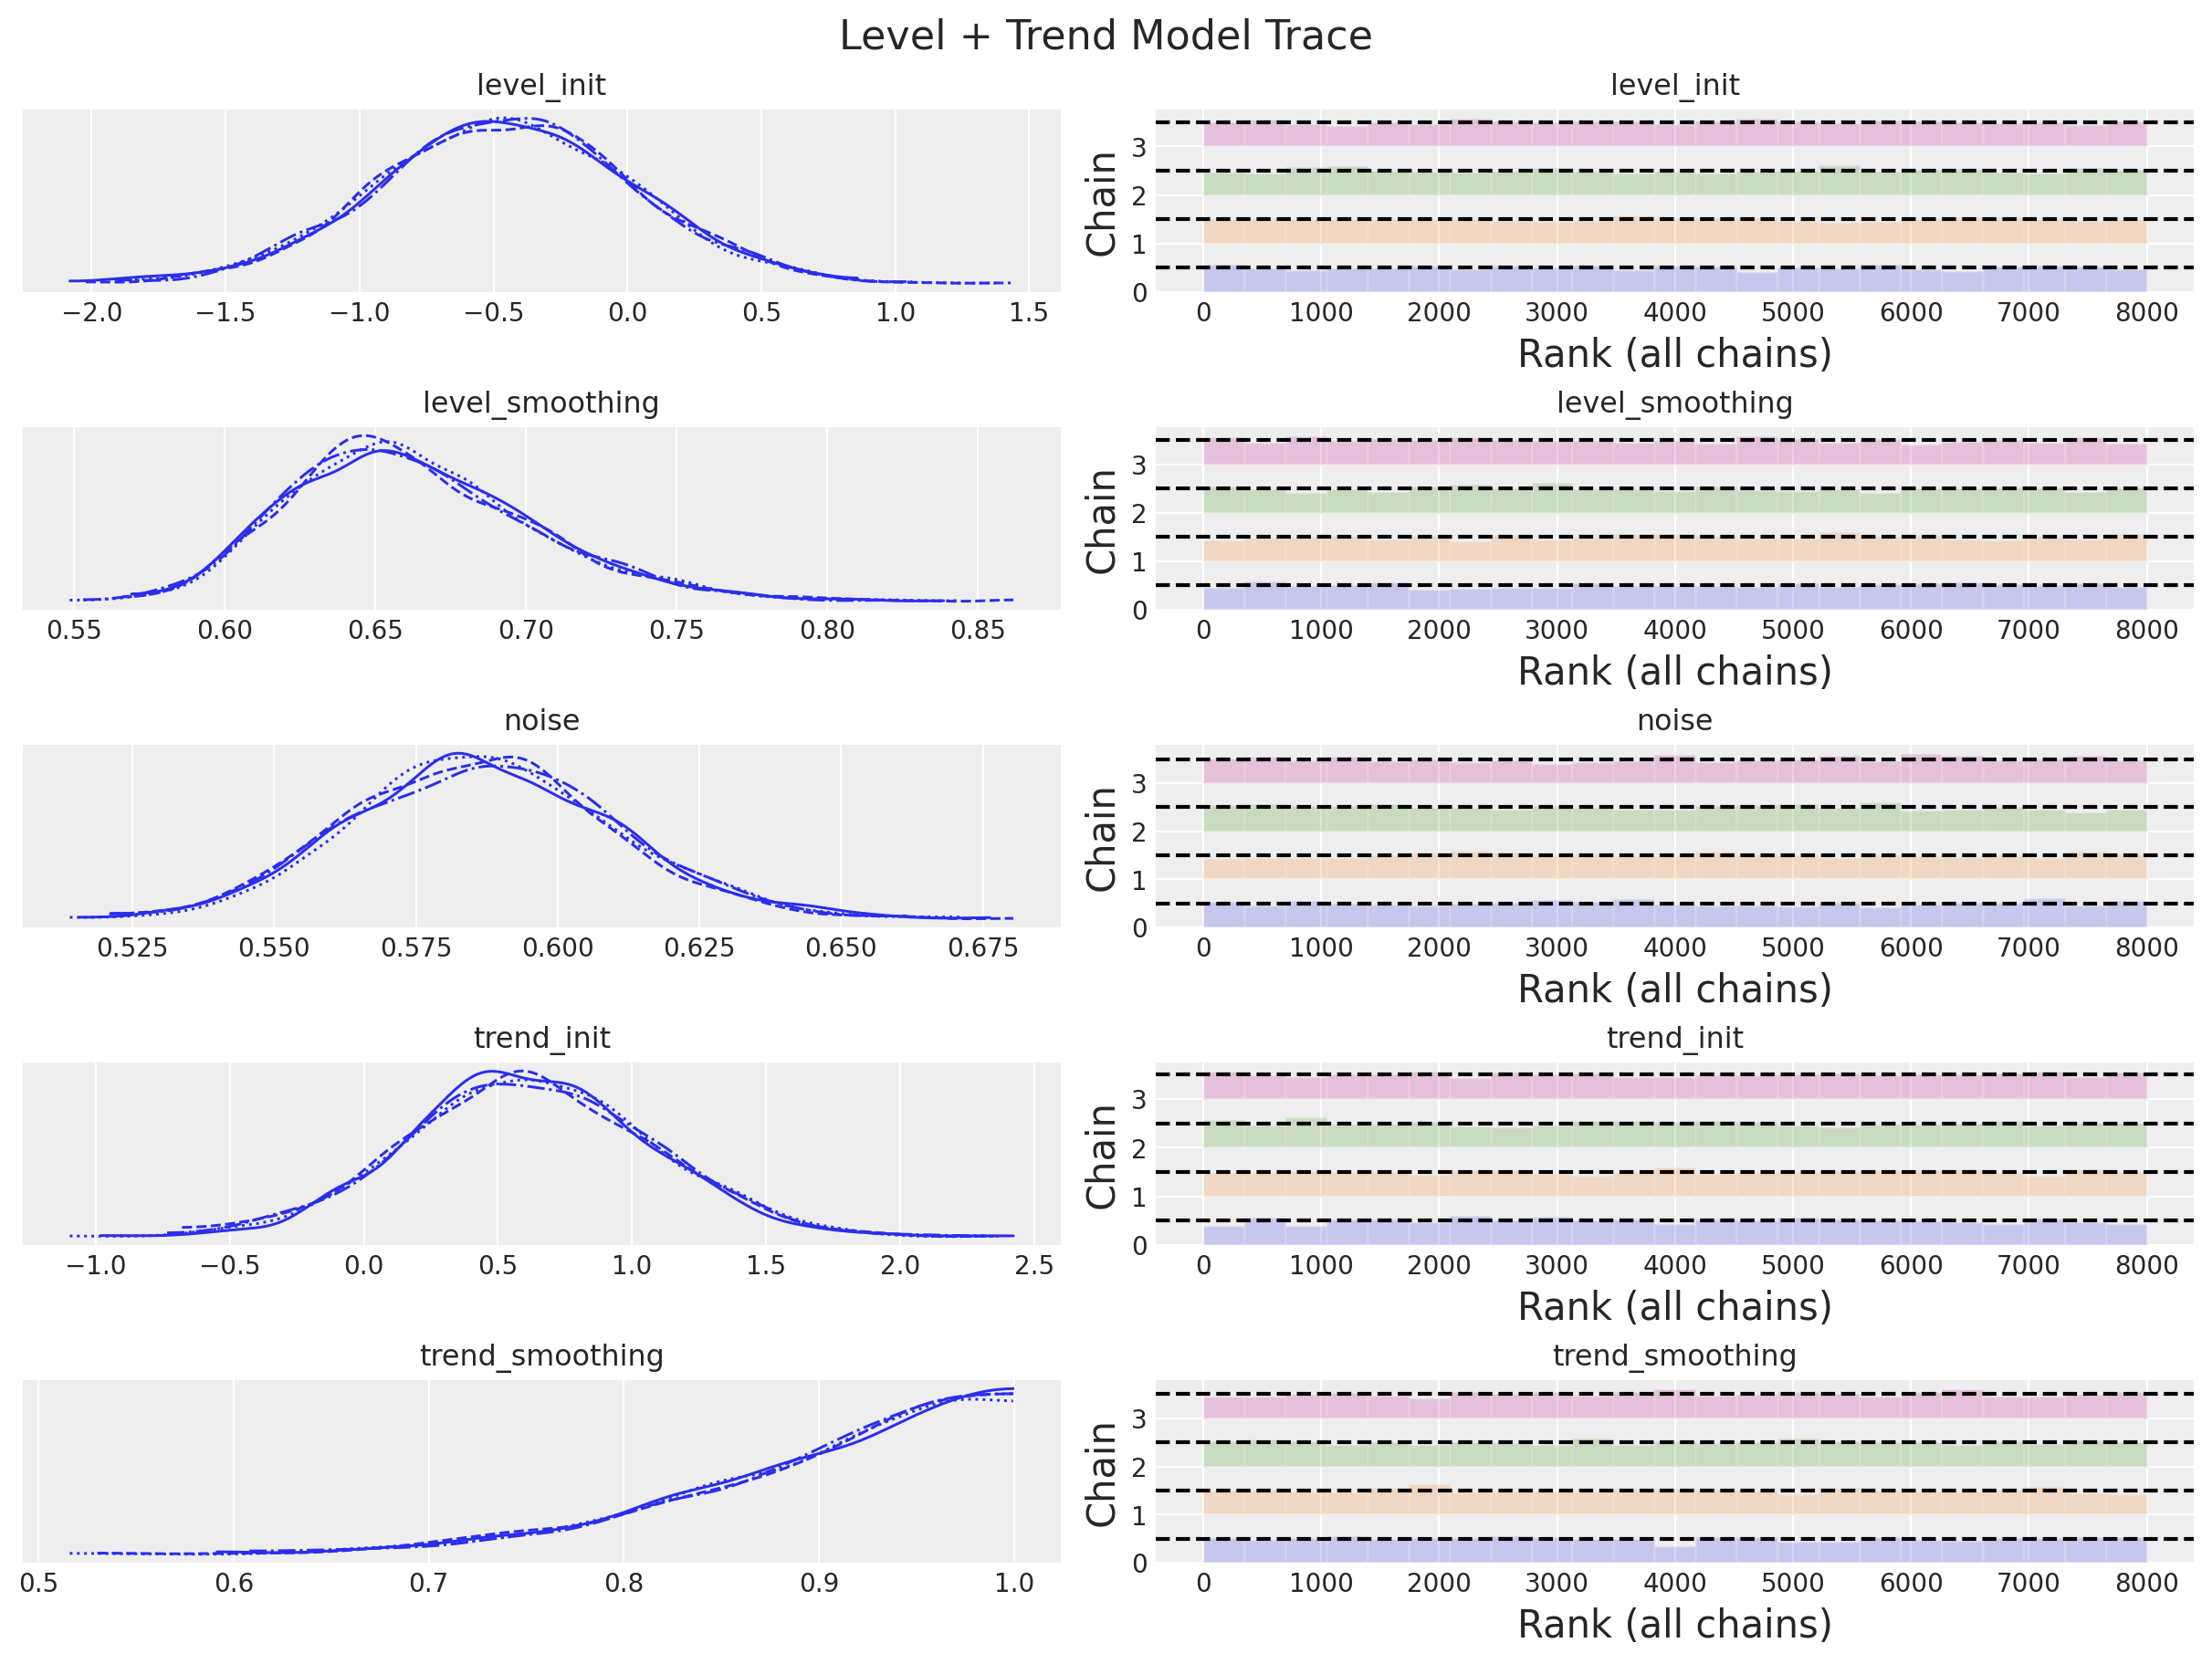

In [23]:
axes = az.plot_trace(
    data=level_trend_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Level + Trend Model Trace", fontsize=16)

### Forecast

In [24]:
rng_key, rng_subkey = random.split(key=rng_key)
level_trend_forecast = forecast(
    rng_subkey, level_trend_model, level_trend_mcmc.get_samples(), y_train, y_test.size
)

level_trend_posterior_predictive = az.from_numpyro(
    posterior_predictive=level_trend_forecast,
    coords={"t": range(n_train, n)},
    dims={"y_forecast": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Level + Trend Model Forecast')]

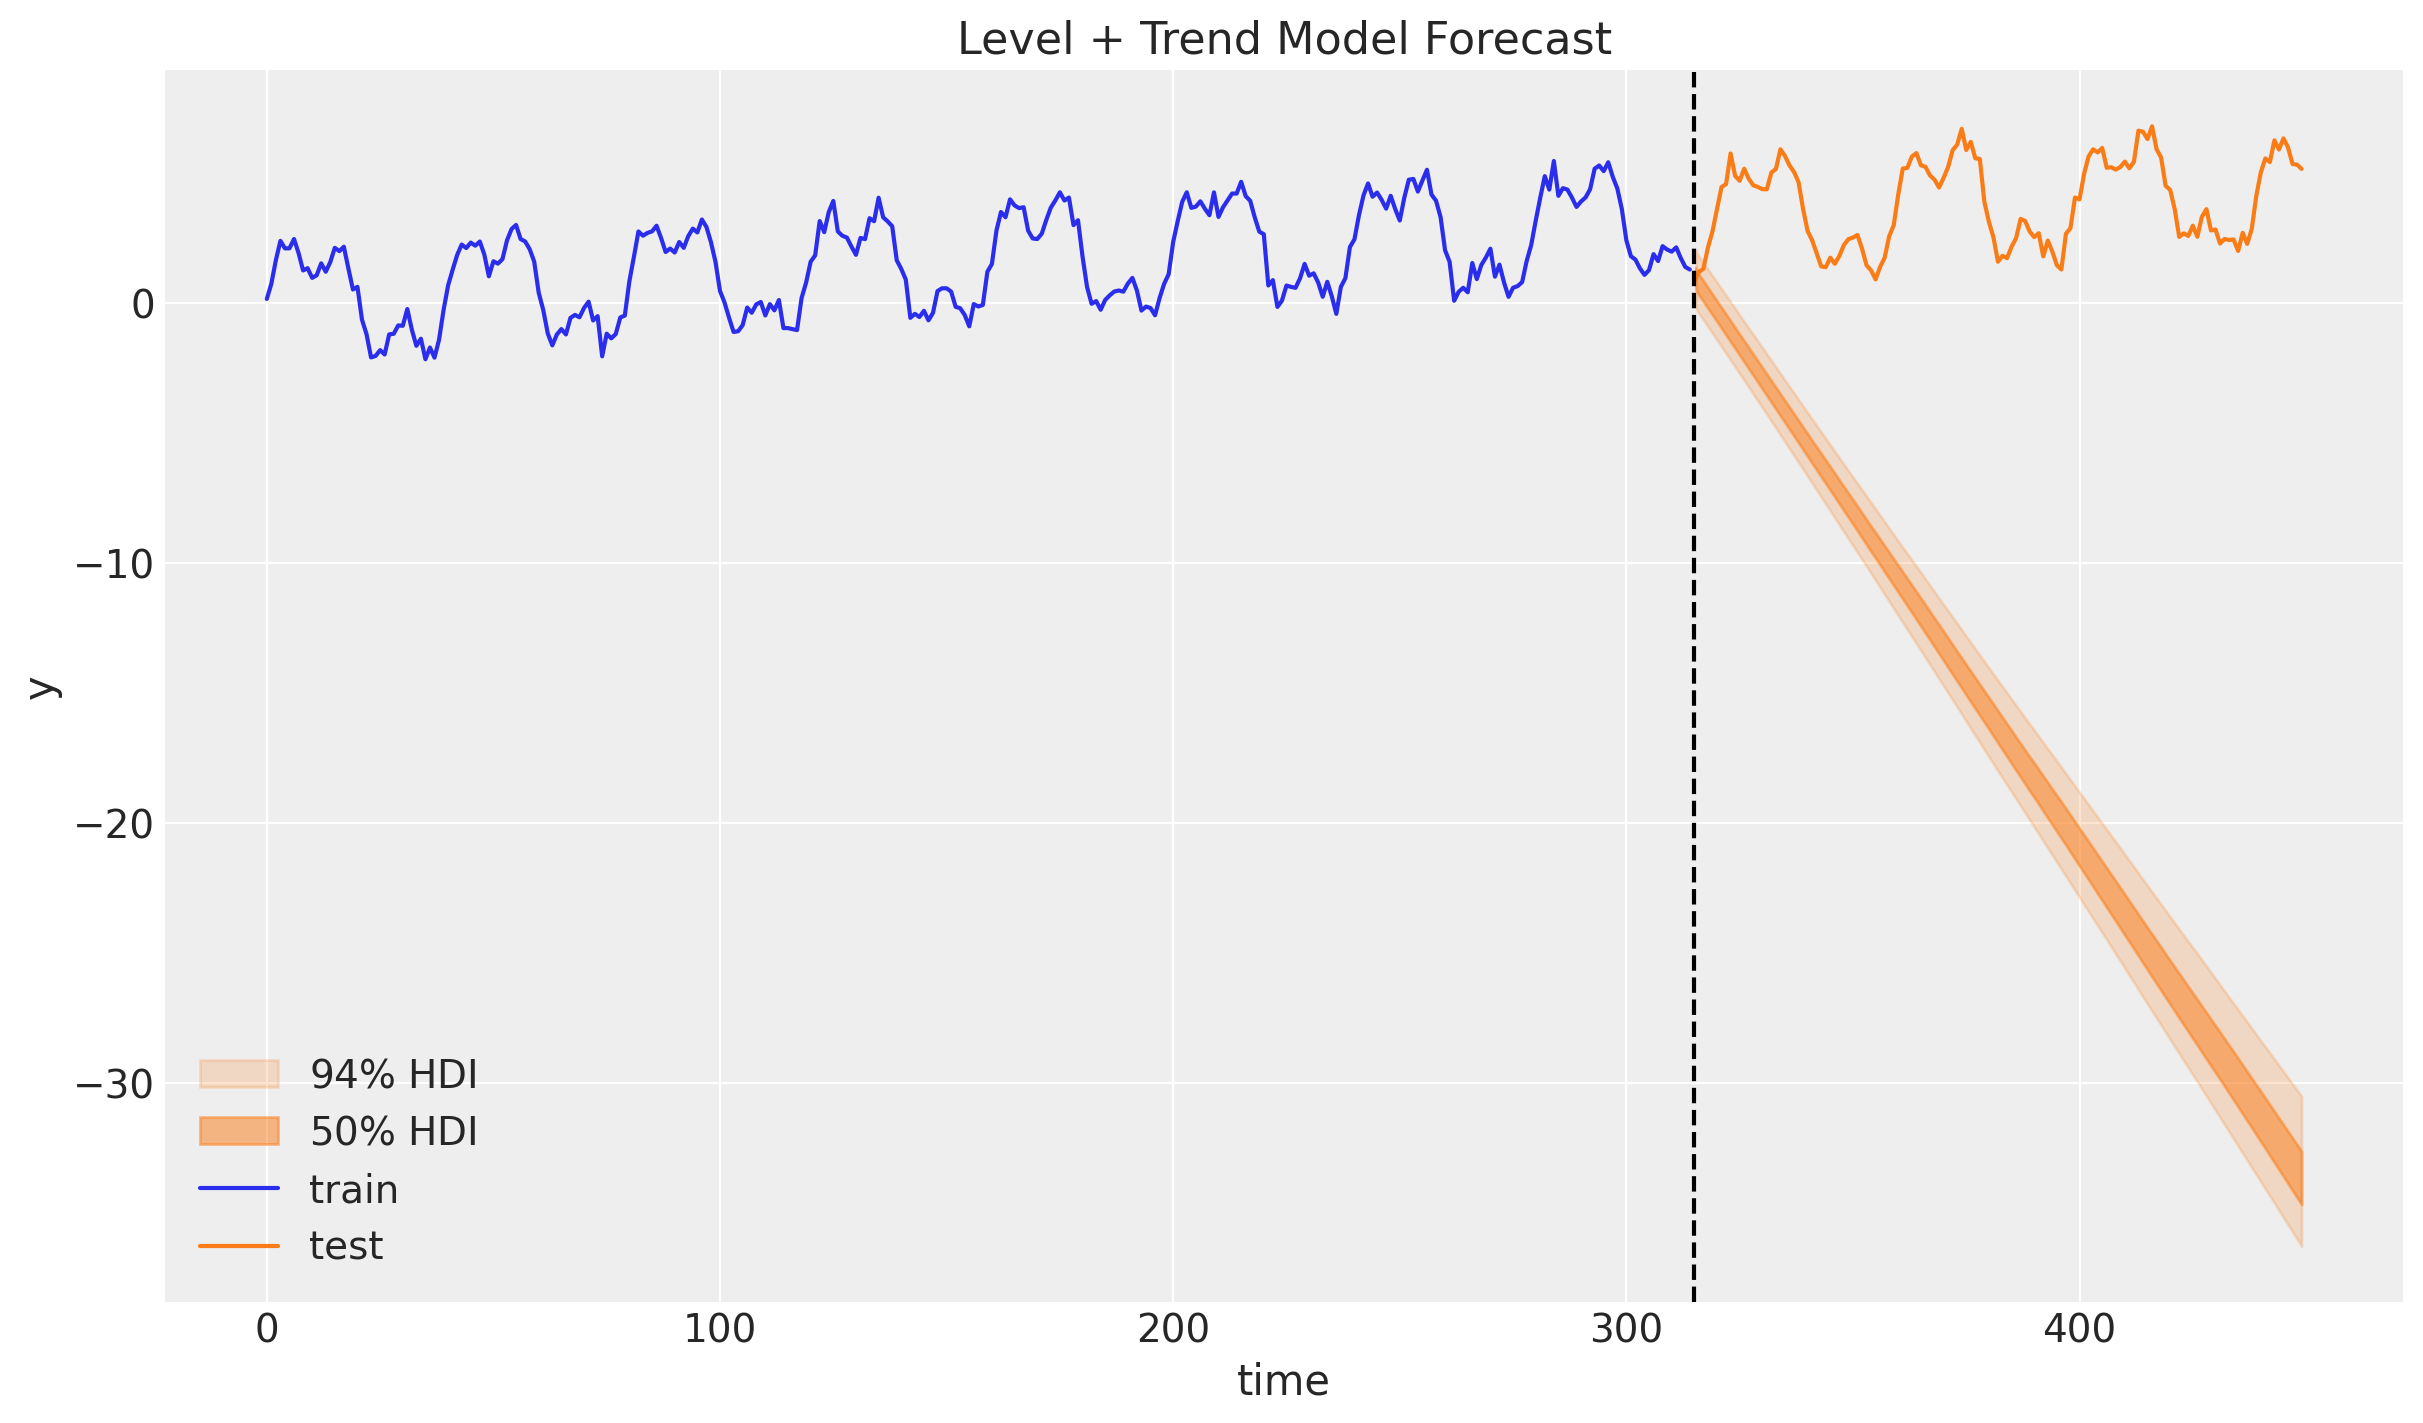

In [25]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=range(n_train, n),
    y=level_trend_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=range(n_train, n),
    y=level_trend_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(range(n_train), y_train, color="C0", label="train")
ax.plot(range(n_train, n), y_test, color="C1", label="test")
ax.axvline(x=n_train, c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level + Trend Model Forecast")